# ERA/MODIS joining

This notebook provides a worked example of how to link ERA5 reanalysis data with real-world MODIS observations in both time and space.

It is a copy of notebooks 2 and 3, but sticking with native `xarray` rather than converting back and forth to pandas.

# 1. ERA5

The ERA5 data is on a reduced Gaussian grid, N320. 

We have the ERA data in monthly files.

For this NB, we will just load a single month:

In [22]:
import xarray as xr
ERA = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/sfc_unstructured_2018_01.grib'
ds_ERA_orig = xr.open_dataset(ERA, engine="cfgrib")

In [23]:
ds_ERA = ds_ERA_orig

In [25]:
#Calculate long1 from long3
ds_ERA = ds_ERA.assign_coords(longitude=(((ds_ERA.longitude + 180) % 360) - 180))

# 2. MODIS

We have the MODIS data in daily files. For this NB we will just load 1 day of data:

Note that this is a data array object, not a dataset

In [312]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
f = 'aquaDay_errorGTE03K_04km_2020-01-24.tif'
da = xr.open_rasterio(root+f)

In [313]:
da

<xarray.DataArray (band: 1, y: 5400, x: 10800)>
[58320000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 89.98 89.95 89.92 89.88 ... -89.88 -89.92 -89.95 -89.98
  * x        (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0
Attributes:
    transform:      (0.03333333333333333, 0.0, -180.0, 0.0, -0.03333333333333...
    crs:            +init=epsg:4326
    res:            (0.03333333333333333, 0.03333333333333333)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('LST_Day_1km',)
    AREA_OR_POINT:  Area

In [233]:
#Load the data and make a copy before we start making edits
MODIS = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/terraDayTime_errorGTE03K_04km_2018-01-01.tif'
da_MODIS_orig =  xr.open_rasterio(MODIS)
da_MODIS = da_MODIS_orig

In [311]:
da_MODIS

<xarray.DataArray (band: 1, y: 5400, x: 10800)>
[58320000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 89.98 89.95 89.92 89.88 ... -89.88 -89.92 -89.95 -89.98
  * x        (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0
Attributes:
    transform:      (0.03333333333333333, 0.0, -180.0, 0.0, -0.03333333333333...
    crs:            +init=epsg:4326
    res:            (0.03333333333333333, 0.03333333333333333)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('Day_view_time',)
    AREA_OR_POINT:  Area

In [314]:
#Add this data array to a new dataset
ds_MODIS = da_MODIS.squeeze('band').to_dataset(name='local_solar_time_uncorrected')
display(ds_MODIS)

<xarray.Dataset>
Dimensions:                       (y: 5400, x: 10800)
Coordinates:
    band                          int64 1
  * y                             (y) float64 89.98 89.95 ... -89.95 -89.98
  * x                             (x) float64 -180.0 -179.9 ... 179.9 180.0
Data variables:
    local_solar_time_uncorrected  (y, x) float32 ...

In [316]:
ds_MODIS = da_MODIS.to_dataframe(name='XXX')

In [320]:
a = np.unique(ds_MODIS.index.get_level_values('x'))

In [331]:
a[int(1.3*len(a)/2)]

54.01666666666665

In [330]:
ds_MODIS.query('x == 71.98333333333332')

XXX
band y          x                  
1     89.983333 71.983333       NaN
      89.950000 71.983333       NaN
      89.916667 71.983333       NaN
      89.883333 71.983333       NaN
      89.850000 71.983333       NaN
...                             ...
     -89.850000 71.983333  1.750000
     -89.883333 71.983333  1.645000
     -89.916667 71.983333  1.735000
     -89.950000 71.983333  2.410000
     -89.983333 71.983333  3.446667

[5400 rows x 1 columns]

In [332]:
ds_MODIS.query('x == 54.01666666666665')

XXX
band y          x                  
1     89.983333 54.016667       NaN
      89.950000 54.016667       NaN
      89.916667 54.016667       NaN
      89.883333 54.016667       NaN
      89.850000 54.016667       NaN
...                             ...
     -89.850000 54.016667  1.645000
     -89.883333 54.016667  1.590000
     -89.916667 54.016667  1.620000
     -89.950000 54.016667  3.250000
     -89.983333 54.016667  3.466667

[5400 rows x 1 columns]

In [235]:
%%time

#Create some extra variables / data arrays
ds_MODIS['local_solar_time'] = ds_MODIS['local_solar_time_uncorrected']/0.02*0.1           # Correct the LST by some scaling factor
ds_MODIS['UTC'] = (ds_MODIS['local_solar_time'] - ds_MODIS['x']/15.0 ) * 3600              # Correct LST to UTC, with the unit being seconds

#Get the date of this file from the fname
date_string =MODIS.split('_')[-1].split('.')[0].replace('-','')
date = pd.to_datetime(date_string, format='%Y%m%d') #Creates Timestamp object, pandas equivalent of np.datetime64

#Use date and UTC to create a definitive absolute timestamp, rounded to the nearest hour
ds_MODIS['time'] = (date + ds_MODIS['UTC'].astype("timedelta64[s]")).dt.round('H')


CPU times: user 3.18 s, sys: 1.22 s, total: 4.4 s
Wall time: 4.4 s


In [212]:
ds_MODIS

<xarray.Dataset>
Dimensions:                       (y: 5400, x: 10800)
Coordinates:
    band                          int64 1
  * y                             (y) float64 89.98 89.95 ... -89.95 -89.98
  * x                             (x) float64 -180.0 -179.9 ... 179.9 180.0
Data variables:
    local_solar_time_uncorrected  (y, x) float32 nan nan nan ... 2.187 2.187
    local_solar_time              (y, x) float32 nan nan nan ... 10.93 10.93
    UTC                           (y, x) float64 nan nan ... -3.836e+03
    time                          (y, x) datetime64[ns] NaT ... 2017-12-31T23...

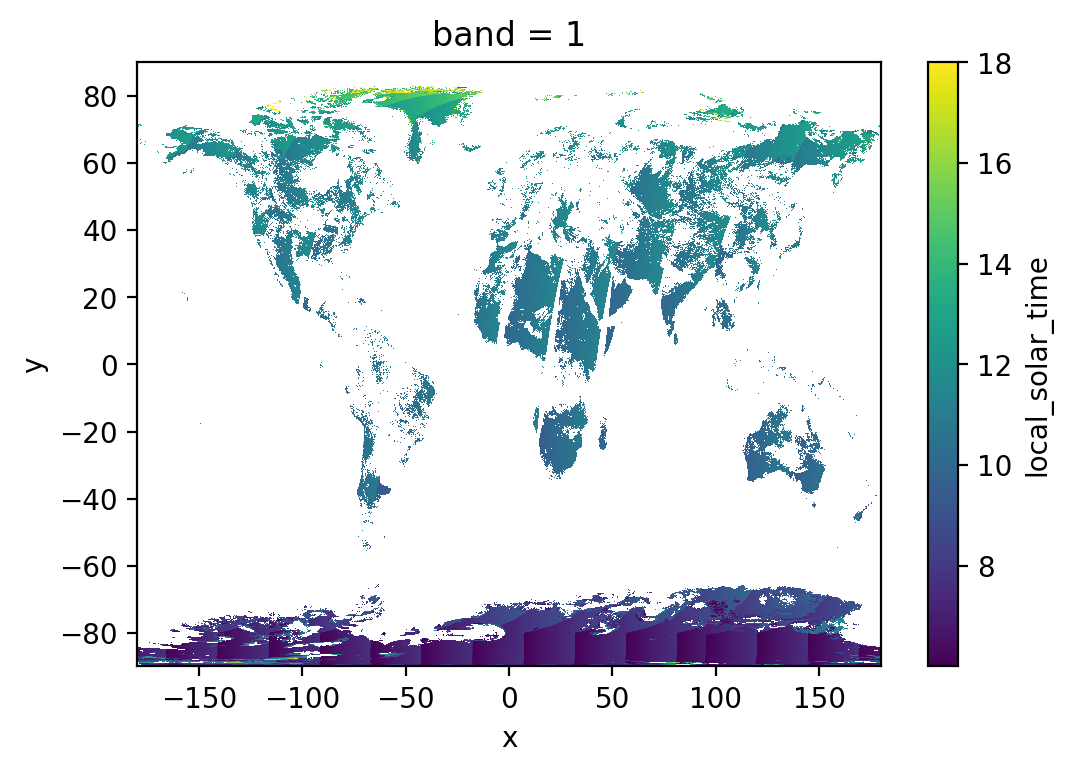

In [213]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
UTC = ds_MODIS['local_solar_time']
UTC.plot()

In [217]:
#ds_MODIS_new = ds_MODIS.expand_dims('time')
ds_MODIS_new = ds_MODIS.set_coords('time')

In [223]:
ds_MODIS_new['time'].to_index()

ValueError: IndexVariable objects must be 1-dimensional

# 3. Combining
We have the ERA data over a month and the MODIS data over a ~day.

We can grab a whole day of ERA data as: 


In [196]:
ds_ERA_1day = ds_ERA.sel(time = '2018-01-01')

or else just get an hour

In [197]:
ds_ERA_1hour = ds_ERA.sel(time = '2018-01-01T22:00:00.000000000')

In [256]:
ds_ERA_1hour

<xarray.Dataset>
Dimensions:     (values: 542080)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2018-01-01T22:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... -80.0 -60.0 -40.0 -20.0
    valid_time  datetime64[ns] 2018-01-01T22:00:00
Dimensions without coordinates: values
Data variables:
    sp          (values) float32 ...
    msl         (values) float32 ...
    u10         (values) float32 ...
    v10         (values) float32 ...
    t2m         (values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-19T13:48 GRIB to CDM+CF via cfgrib-0.9.9...

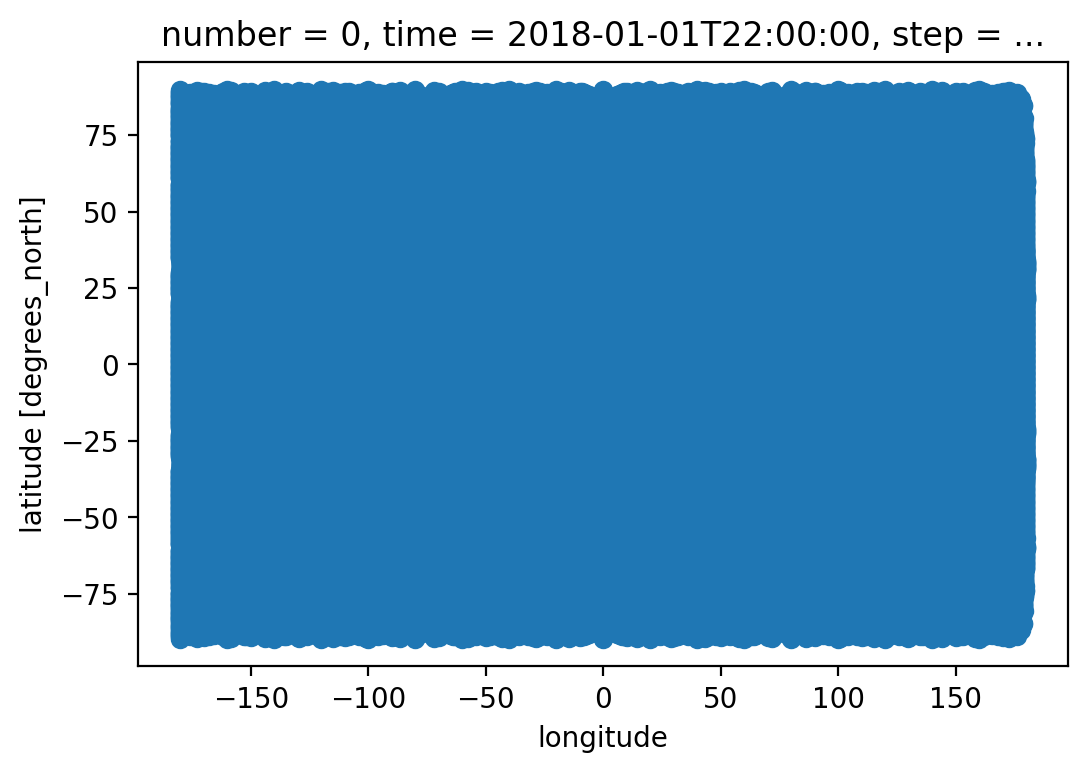

In [261]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
ds_ERA_1hour.plot.scatter('longitude','latitude')
#UTC = ds_ERA_1hour['t2m']
#UTC.plot()

The MODIS data is not indexed on time, so instead we can do:

In [294]:
ds_MODIS.time.type

AttributeError: 'DataArray' object has no attribute 'type'

In [239]:
temp = ds_MODIS.where(ds_MODIS.time == '2017-12-31T19:00:00.000000000',drop=True)

In [291]:
temp = ds_MODIS.set_coords('time')
display(temp)

<xarray.Dataset>
Dimensions:                       (y: 5400, x: 10800)
Coordinates:
    band                          int64 1
  * y                             (y) float64 89.98 89.95 ... -89.95 -89.98
  * x                             (x) float64 -180.0 -179.9 ... 179.9 180.0
    time                          (y, x) datetime64[ns] NaT ... 2017-12-31T23...
Data variables:
    local_solar_time_uncorrected  (y, x) float32 nan nan nan ... 2.187 2.187
    local_solar_time              (y, x) float32 nan nan nan ... 10.93 10.93
    UTC                           (y, x) float64 nan nan ... -3.836e+03

In [292]:
temp1hr = temp.sel(time = '2018-01-01T22:00:00.000000000')

KeyError: 'no index found for coordinate time'

In [220]:
ds_MODIS_1hour = ds_MODIS_new.sel(time = '2018-01-01T22:00:00.000000000')

KeyError: 'no index found for coordinate time'

The ERA data covers the global surface, whilst the MODIS data only covers a subset - the points MODIS was able to observe within that hour.


---


Now, for every entry in `ERA1` we want to find the closest entry in `MODIS1`. This is a classic [nearest neighbours problem](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) which we can solve with inbuilt functions. We use the Haversine distance as our closeness metric. 

**This search is currently our most demanding step. How can we reduce this demand? No need to look in the entire ERA set...We could also potentially use query_radius...**

This general process can then be repeated for each hour snapshot.

---

# 3.1 Combining, but faster

It seems wasteful to find matching points over the entire ERA set since we are going to end up culling most of them due to the tolerance cutoffs.

Lets impose a trivial requirement on the ERA1 set to be within the longitude limits set by the MODIS1 set:

In [295]:
ds_ERA_1hour

<xarray.Dataset>
Dimensions:     (values: 542080)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2018-01-01T22:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... -80.0 -60.0 -40.0 -20.0
    valid_time  datetime64[ns] 2018-01-01T22:00:00
Dimensions without coordinates: values
Data variables:
    sp          (values) float32 ...
    msl         (values) float32 ...
    u10         (values) float32 ...
    v10         (values) float32 ...
    t2m         (values) float32 250.5 250.5 250.5 250.4 ... 248.9 248.8 248.8
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-19T13:48 GRIB to CDM+CF via cfgrib-0.9.9...

In [301]:
ds_MODIS

<xarray.Dataset>
Dimensions:                       (y: 5400, x: 10800)
Coordinates:
    band                          int64 1
  * y                             (y) float64 89.98 89.95 ... -89.95 -89.98
  * x                             (x) float64 -180.0 -179.9 ... 179.9 180.0
Data variables:
    local_solar_time_uncorrected  (y, x) float32 nan nan nan ... 2.187 2.187
    local_solar_time              (y, x) float32 nan nan nan ... 10.93 10.93
    UTC                           (y, x) float64 nan nan ... -3.836e+03
    time                          (y, x) datetime64[ns] NaT ... 2017-12-31T23...

In [302]:
da = ds_MODIS.local_solar_time

In [304]:
da.where(da < 10,drop=True)

<xarray.DataArray 'local_solar_time' (y: 2823, x: 10800)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ..., 7.200001 , 7.200001 ,
        7.200001 ],
       [      nan,       nan,       nan, ..., 7.3250003, 7.3250003,
        7.3250003]], dtype=float32)
Coordinates:
    band     int64 1
  * y        (y) float64 82.78 82.75 82.72 82.58 ... -89.85 -89.88 -89.92 -89.95
  * x        (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0

In [65]:
string_query = 'x > %.9f & x < %.9f' % (min(MODIS1['x']),max(MODIS1['x']))
ERA1_selected = ERA1.query(string_query)

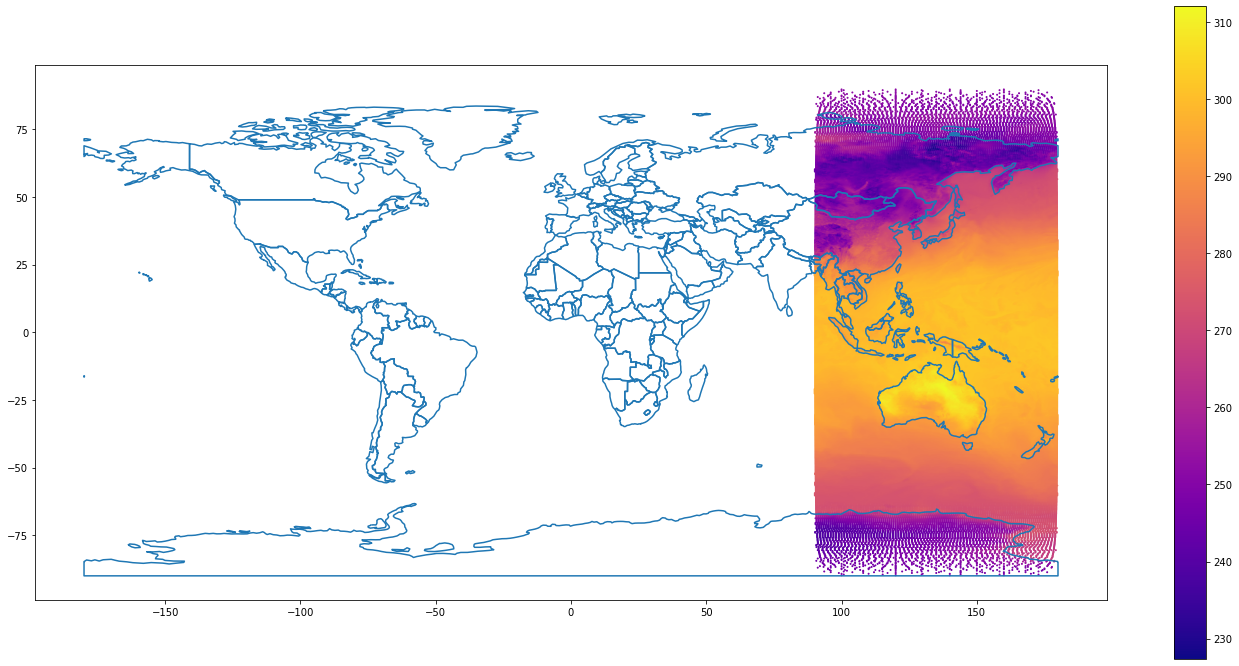

In [66]:
plot_world_map(ERA1_selected, 't2m')

We can also use a generalisation of the above Ball Tree method to let the computer choose the best NN algo for the set of data

In [67]:
%%time

from sklearn.neighbors import NearestNeighbors
import numpy as np

# Setup NearestNeighbours using MODIS as reference dataset
# Use Haversine calculate distance between points on the earth from lat/long
NN = NearestNeighbors(n_neighbors=1, metric='haversine') #algorithm = balltree, kdtree or brutie force


NN.fit(np.deg2rad(MODIS1[['y', 'x']].values))



query_lats = ERA1_selected['y'].astype(np.float64)
query_lons = ERA1_selected['x'].astype(np.float64)
X = np.deg2rad(np.c_[query_lats, query_lons])
distances, indices = NN.kneighbors(X, return_distance=True)


r_km = 6371 # multiplier to convert to km (from unit distance)
distances = distances*r_km





CPU times: user 5.14 s, sys: 205 µs, total: 5.14 s
Wall time: 5.14 s


These two changes make the matching much faster. Great! Any they also deliver the same result:

In [68]:

#Combine both dfs
df_combined = ERA1_selected.reset_index().join(MODIS1.iloc[indices.flatten()].reset_index(), lsuffix='_ERA',rsuffix='_MODIS')
df_combined['distance'] = distances
df_combined['MODIS_idx'] = indices

#Filter and surface selected columns
#We have set the cutoff arbitratily as 1
df_combined_matches = df_combined.query('distance < 1')
display(df_combined_matches)

,index_ERA,y_ERA,x_ERA,time_ERA,values,number,step,surface,longitude,valid_time,...,time_MODIS,band,local_solar_time_uncorrected,local_solar_time,UTC,date,timeUTC,geometry_MODIS,distance,MODIS_idx
4444,17794,69.554988,174.000000,2018-01-01,17794,0,0 days,0.0,174.000000,2018-01-01,...,2018-01-01,1,2.230000,11.150000,-0.451111,20180101,2017-12-31 23:32:56.000342400,POINT (174.01667 69.55000),0.852543,150
4445,17795,69.554988,174.750000,2018-01-01,17795,0,0 days,0.0,174.750000,2018-01-01,...,2018-01-01,1,2.286667,11.433333,-0.216667,20180101,2017-12-31 23:46:59.999368800,POINT (174.75000 69.55000),0.554674,151
4801,19235,68.711899,172.592593,2018-01-01,19235,0,0 days,0.0,172.592593,2018-01-01,...,2018-01-01,1,2.237143,11.185714,-0.319842,20180101,2017-12-31 23:40:48.570423600,POINT (172.58333 68.71667),0.648649,398
7240,29045,63.653361,166.200000,2018-01-01,29045,0,0 days,0.0,166.200000,2018-01-01,...,2018-01-01,1,2.292500,11.462500,0.381389,20180101,2018-01-01 00:22:53.000342400,POINT (166.21667 63.65000),0.903424,722
7243,29048,63.653361,168.000000,2018-01-01,29048,0,0 days,0.0,168.000000,2018-01-01,...,2018-01-01,1,2.258750,11.293750,0.094861,20180101,2018-01-01 00:05:41.499312000,POINT (167.98333 63.65000),0.903424,725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134940,541973,-88.945191,108.000000,2018-01-01,541973,0,0 days,0.0,108.000000,2018-01-01,...,2018-01-01,1,1.380000,6.900000,-0.298889,20180101,2017-12-31 23:42:03.999913201,POINT (107.98333 -88.95000),0.535806,601358
134941,541974,-88.945191,117.000000,2018-01-01,541974,0,0 days,0.0,117.000000,2018-01-01,...,2018-01-01,1,1.590000,7.950000,0.151111,20180101,2018-01-01 00:09:04.000600799,POINT (116.98333 -88.95000),0.535806,601628
134962,542067,-89.784877,100.000000,2018-01-01,542067,0,0 days,0.0,100.000000,2018-01-01,...,2018-01-01,1,1.342500,6.712500,0.082500,20180101,2018-01-01 00:04:56.999485200,POINT (99.45000 -89.78333),0.287338,618656
134963,542068,-89.784877,120.000000,2018-01-01,542068,0,0 days,0.0,120.000000,2018-01-01,...,2018-01-01,1,1.520000,7.600000,-0.325556,20180101,2017-12-31 23:40:27.999656400,POINT (118.88333 -89.78333),0.498351,619093


<AxesSubplot:>

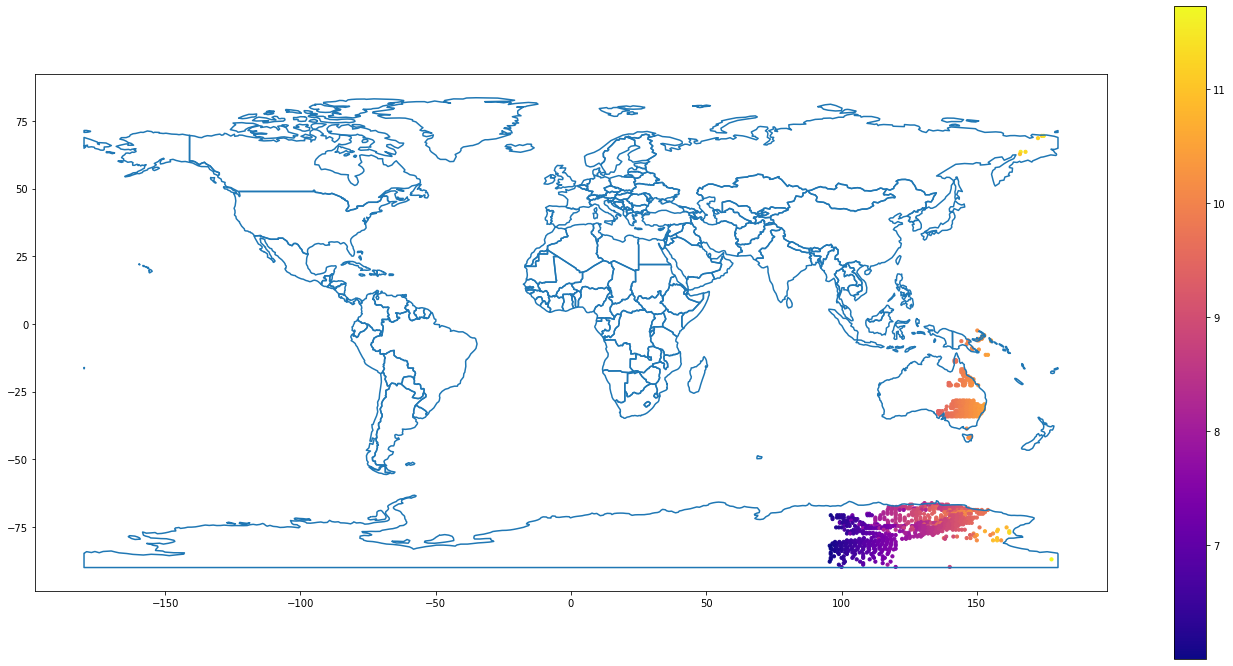

In [69]:
df = df_combined_matches
q = 'local_solar_time'
#Plot land outlines
ax=world.boundary.plot(figsize=(24,12))

#Create geopandas
geometry = [Point(xy) for xy in zip(df['x_ERA'], df['y_ERA'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#Plot it
gdf.plot(ax=ax,column=q, cmap='plasma', legend=True,markersize=10)






# Appendix A - MODIS snapshots at each hour over 1 day

# Scratch space

---

In [88]:
def haversine_np(lon1, lat1, lon2, lat2):
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [89]:
haversine_np(171.116667,70.05,174.0,69.55)

123.78902425712415